In [64]:
import fastbook
fastbook.setup_book()

from fastbook import *
from fastai.vision.widgets import *

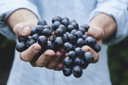

In [65]:
from PIL import Image
path = 'images/'
im = Image.open(path + 'grape/grape-0.jpg')
im.to_thumb(128,128)

In [66]:
from fastai.vision.all import *
filenames = get_image_files(path)
filenames

(#3397) [Path('images/apple/apple-fruit-81.jpg'),Path('images/apple/apple-fruit-293.jpg'),Path('images/apple/apple-fruit-287.jpg'),Path('images/apple/apple-fruit-95.jpg'),Path('images/apple/apple-fruit-250.jpg'),Path('images/apple/apple-fruit-42.jpg'),Path('images/apple/apple-fruit-536.jpg'),Path('images/apple/apple-fruit-522.jpg'),Path('images/apple/apple-fruit-56.jpg'),Path('images/apple/apple-fruit-244.jpg')...]

In [67]:
failed = verify_images(filenames)
failed

(#0) []

In [68]:
fruits = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [69]:
dls = fruits.dataloaders(path)

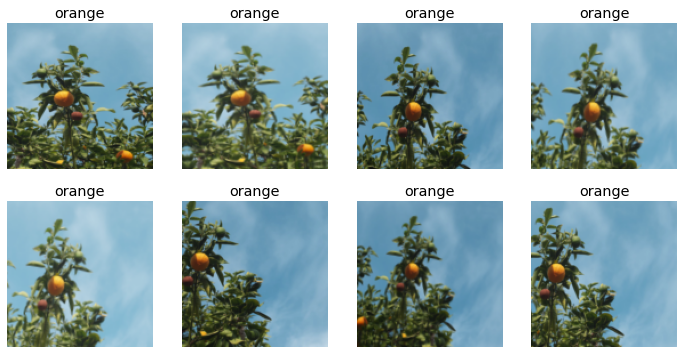

In [70]:
fruits = fruits.new(item_tfms=RandomResizedCrop(128, min_scale=0.5), batch_tfms=[Rotate(), Flip(), Brightness()])
dls = fruits.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [71]:
metrics = [accuracy, error_rate]
our_out_of_the_box_model = cnn_learner(dls, vgg19_bn, loss_func=CrossEntropyLossFlat(), metrics=metrics )
our_out_of_the_box_model.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,error_rate,time


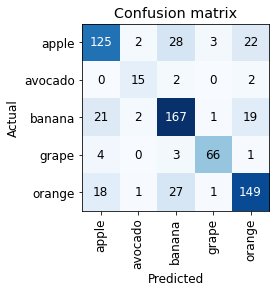

In [ ]:
interp = ClassificationInterpretation.from_learner(our_out_of_the_box_model)
interp.plot_confusion_matrix()

In [ ]:
our_out_of_the_box_model.save('model')
our_out_of_the_box_model.export()